# Linear bias correction

Apply linear bias correction methods (below) to each of the pre-trained embeddings (VGGish, OpenL3, YAMNet):
- ` ` (original): original embedding
- `LDA`: single bias (dataset bias) correction with linear discriminant analysis (LDA)
- `mLDA`: multiple bias (per-genre dataset bias) correction with LDA

In [1]:
%matplotlib inline

import sys 
# add parental directory to Python path
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import os

import warnings
warnings.filterwarnings('ignore')

from deem import deem

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 
              'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

# only consider 10 mutual classes between Openmic and IRMAS dataset
with open("../data/openmic-2018/openmic_classmap_10.json", "r") as f: 
    openmic_class_map = json.load(f)
    
with open("../data/class_align.json", "r") as f: 
    class_align = json.load(f)

with open("../data/genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("../data/instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

# select 'global' or 'classwise' bias correction
# 'global' uses only dataset identity as additional information 
# while 'classwise' also use class-labels

add_info = 'classwise'
save_dir = os.path.join('../results', add_info)

## VGGish

In [3]:
embedding = 'vggish'
debias_method = ''  # no bias correction, i.e. use the original embedding

deb = deem(embedding = embedding, debias_method = debias_method, feature_dir='../embeddings.h5', 
           instrument_map=instrument_map, genre_map=genre_map, param_grid=param_grid, 
           class_align=class_align, add_info = add_info)

irmas_feature = deb.load_irmas()
openmic_feature = deb.load_openmic()

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

Load IRMAS data:


  2%|▏         | 157/6705 [00:00<00:08, 788.50it/s]

100%|██████████| 6705/6705 [00:03<00:00, 1923.14it/s]


# Train: 4997,  # Test: 1666
Load OpenMIC data:


100%|██████████| 5085/5085 [00:00<00:00, 11539.88it/s]


# Train: 6838,  # Test: 2491
Train on irmas, test on irmas


100%|██████████| 10/10 [00:58<00:00,  5.81s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [01:05<00:00,  6.51s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:50<00:00,  5.04s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


In [4]:
debias_method = '-lda'

deb.debias_method = debias_method

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

Train on irmas, test on irmas


100%|██████████| 10/10 [00:47<00:00,  4.79s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:48<00:00,  4.89s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:50<00:00,  5.05s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]


In [5]:
debias_method = '-mlda'

deb.debias_method = debias_method

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

deb.result_all.to_csv(os.path.join(save_dir, 'result_' + embedding + debias_method + '.csv'), index=False)
result_all = deb.result_all

Train on irmas, test on irmas


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:40<00:00,  4.02s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


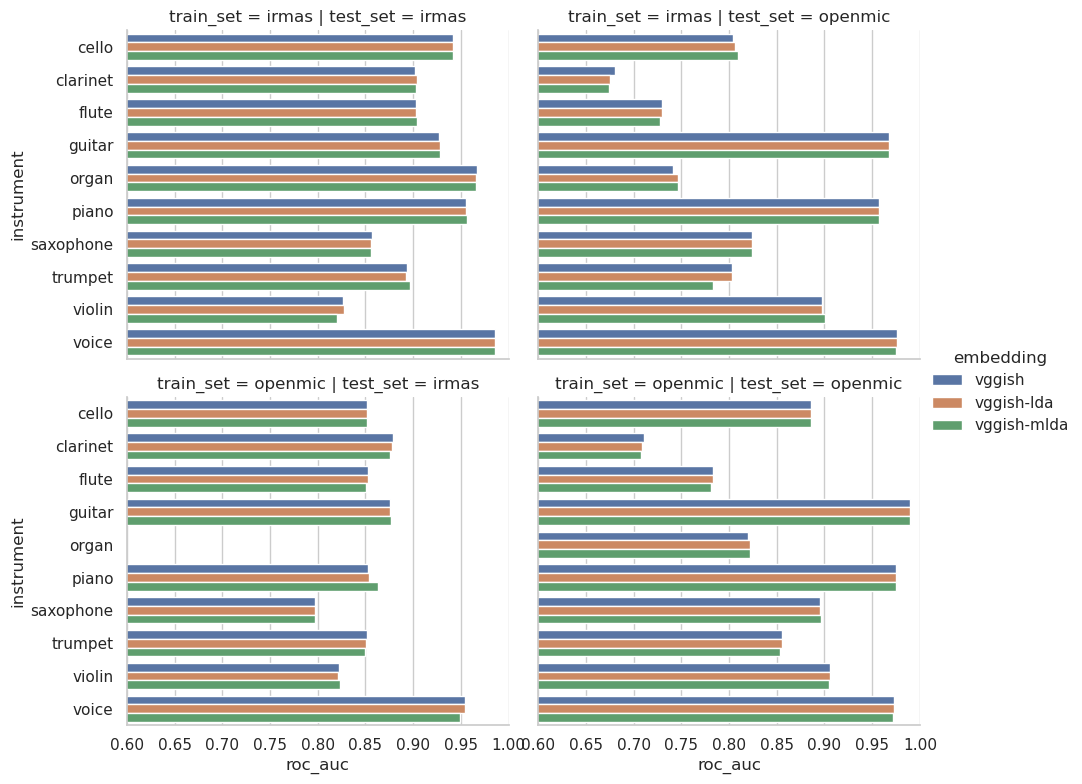

In [6]:
df = pd.read_csv(os.path.join(save_dir, 'result_' + embedding + debias_method + '.csv'))

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2, ci=None)
plt.xlim([0.6,1])
plt.savefig(os.path.join(save_dir, embedding  + debias_method + '.pdf'), bbox_inches='tight')

## OpenL3

In [7]:
embedding = 'openl3'
debias_method = ''

deb = deem(embedding = embedding, debias_method = debias_method, feature_dir='../embeddings.h5', 
           instrument_map=instrument_map, genre_map=genre_map, param_grid=param_grid, 
           class_align=class_align, add_info = add_info)

irmas_feature = deb.load_irmas()
openmic_feature = deb.load_openmic()

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

Load IRMAS data:


100%|██████████| 6705/6705 [00:33<00:00, 202.18it/s]


# Train: 4997,  # Test: 1666
Load OpenMIC data:


100%|██████████| 5085/5085 [00:00<00:00, 27961.15it/s]


# Train: 6838,  # Test: 2491
Train on irmas, test on irmas


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:35<00:00,  3.52s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


In [8]:
debias_method = '-lda'

deb.debias_method = debias_method

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

Train on irmas, test on irmas


100%|██████████| 10/10 [00:36<00:00,  3.63s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:36<00:00,  3.62s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:38<00:00,  3.82s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


In [9]:
debias_method = '-mlda'

deb.debias_method = debias_method

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

deb.result_all.to_csv(os.path.join(save_dir, 'result_' + embedding + debias_method + '.csv'), index=False)
result_all = result_all.append(deb.result_all)

Train on irmas, test on irmas


100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:44<00:00,  4.41s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:44<00:00,  4.48s/it]


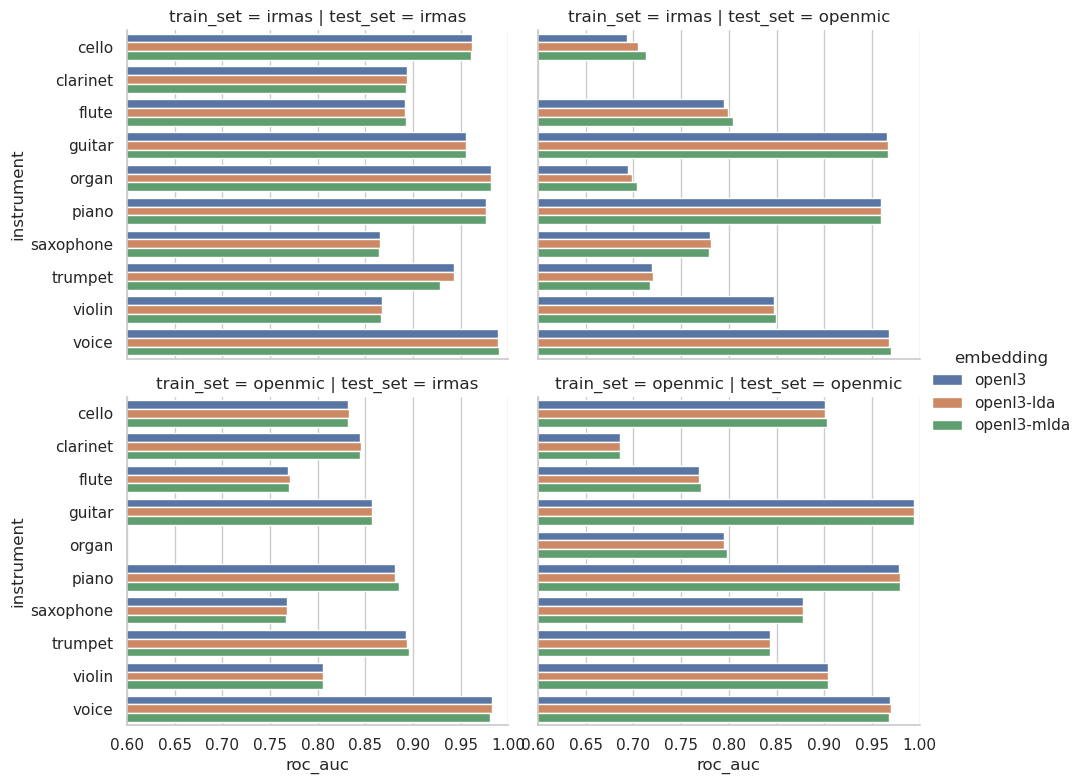

In [10]:
df = pd.read_csv(os.path.join(save_dir, 'result_' + embedding + debias_method + '.csv'))

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2, ci=None)
plt.xlim([0.6,1])
plt.savefig(os.path.join(save_dir, embedding  + debias_method + '.pdf'), bbox_inches='tight')

## YAMNet

In [11]:
embedding = 'yamnet'
debias_method = ''

deb = deem(embedding = embedding, debias_method = debias_method, feature_dir='../embeddings.h5', 
           instrument_map=instrument_map, genre_map=genre_map, param_grid=param_grid,
           class_align=class_align, add_info = add_info)

irmas_feature = deb.load_irmas()
openmic_feature = deb.load_openmic()

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

Load IRMAS data:


100%|██████████| 6705/6705 [00:03<00:00, 2031.82it/s]


# Train: 4997,  # Test: 1666
Load OpenMIC data:


100%|██████████| 5085/5085 [00:00<00:00, 29395.64it/s]


# Train: 6838,  # Test: 2491
Train on irmas, test on irmas


100%|██████████| 10/10 [00:37<00:00,  3.77s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [00:38<00:00,  3.89s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [00:39<00:00,  3.97s/it]


In [12]:
debias_method = '-lda'

deb.debias_method = debias_method

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

Train on irmas, test on irmas


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:56<00:00,  5.60s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [00:58<00:00,  5.84s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [01:02<00:00,  6.24s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [01:03<00:00,  6.37s/it]


In [13]:
debias_method = '-mlda'

deb.debias_method = debias_method

deb.instrument_classfication(train_set='irmas', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='irmas', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='openmic', irmas_feature=irmas_feature, openmic_feature=openmic_feature)
deb.instrument_classfication(train_set='openmic', test_set='irmas', irmas_feature=irmas_feature, openmic_feature=openmic_feature)

deb.result_all.to_csv(os.path.join(save_dir, 'result_' + embedding + debias_method + '.csv'), index=False)
result_all = result_all.append(deb.result_all)

Train on irmas, test on irmas


100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


Train on irmas, test on openmic


100%|██████████| 10/10 [01:08<00:00,  6.90s/it]


Train on openmic, test on openmic


100%|██████████| 10/10 [01:14<00:00,  7.44s/it]


Train on openmic, test on irmas


100%|██████████| 10/10 [01:15<00:00,  7.51s/it]


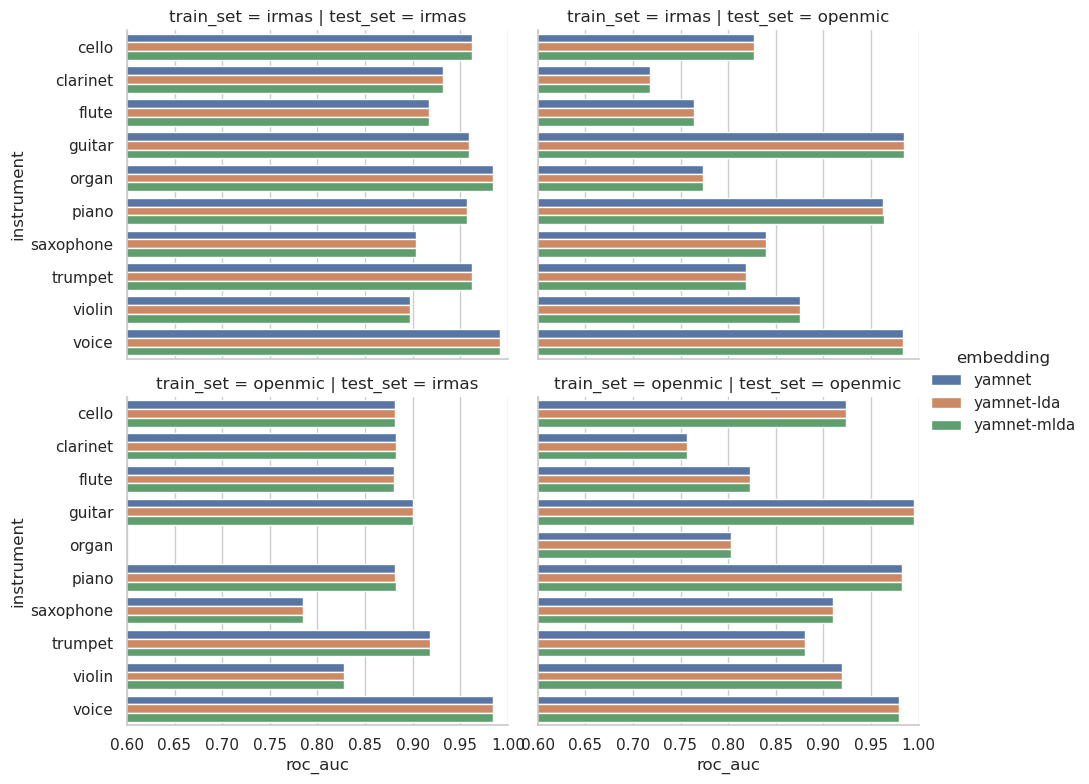

In [14]:
df = pd.read_csv(os.path.join(save_dir, 'result_' + embedding + debias_method + '.csv'))

sns.set_theme(context='notebook', style='whitegrid', palette='deep')

sns.catplot(data=df, row='train_set', col='test_set', y='instrument', x='roc_auc', hue='embedding', kind='bar', 
            height=4, aspect=1.2, ci=None)
plt.xlim([0.6,1])
plt.savefig(os.path.join(save_dir, embedding  + debias_method + '.pdf'), bbox_inches='tight')

In [15]:
result_all.to_csv(os.path.join(save_dir, 'result_linear_all.csv'), index=False)

In [16]:
result_all

,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap,embedding
0,cello,irmas,irmas,0.3015267175572519,0.8404255319148937,0.44382022471910115,94.0,0.8811524609843937,0.9419766119863571,0.6042162765192624,vggish
1,clarinet,irmas,irmas,0.2970027247956403,0.8582677165354331,0.44129554655870445,127.0,0.8343337334933973,0.9015875939484171,0.5907064158870868,vggish
2,flute,irmas,irmas,0.3310104529616725,0.7851239669421488,0.46568627450980393,121.0,0.8691476590636255,0.9033886972104096,0.6236143314373876,vggish
3,guitar,irmas,irmas,0.5584905660377358,0.8554913294797688,0.6757990867579908,346.0,0.82953181272509,0.9275945874934314,0.814941720357818,vggish
4,organ,irmas,irmas,0.4653179190751445,0.9252873563218391,0.6192307692307691,174.0,0.8811524609843937,0.9666266062679116,0.7598714716810079,vggish
...,...,...,...,...,...,...,...,...,...,...,...
115,piano,openmic,irmas,0.20502092050209206,0.8647058823529412,0.33145434047350625,170.0,0.6440576230492197,0.8819440075495439,0.6605719493284202,yamnet-mlda
116,saxophone,openmic,irmas,0.20281124497991967,0.6733333333333333,0.3117283950617284,150.0,0.7322929171668667,0.7844722955145119,0.32209828471861074,yamnet-mlda
117,trumpet,openmic,irmas,0.2875536480686695,0.8933333333333333,0.43506493506493504,150.0,0.7911164465786314,0.9181530343007916,0.6482834206159044,yamnet-mlda
118,violin,openmic,irmas,0.21621621621621623,0.7832167832167832,0.3388804841149773,143.0,0.7376950780312125,0.8277690792464265,0.34408560184179643,yamnet-mlda
